# Modules

In [1]:
import pickle
import ztfimg
import numpy as np
import matplotlib.pyplot as plt

from ztfimg import image
from astropy.io import fits
from scipy.spatial.distance import cdist
from astrobject import baseobject
from astropy import units

# Input

In [2]:
sciimg = '/home/nicolas/Work/Data/ztf/sci/2018/1229/303241/ztf_20181229303241_000695_zr_c12_o_q2_sciimg.fits'
mask = '/home/nicolas/Work/Data/ztf/sci/2018/1229/303241/ztf_20181229303241_000695_zr_c12_o_q2_mskimg.fits'
zimg = image.ScienceImage(sciimg, mask)
zimg.load_source_background()
hdul = fits.open(sciimg)
header = hdul[0].header

### To show, select and convert to code by pressing y

zimg.show("dataclean",show_ps1cal=False, vmin="1", vmax="99")

### Catalogue selection

In [3]:
zimg.extract_sources(data="dataclean", setmag=True)
zimg.load_ps1_calibrators()

## Select isolated stars depending on mag and arcsecs isolation

In [4]:
isosources = zimg.catalogs.get_isolated('sources')
zimg.catalogs.set_catalog(isosources, "isosources")

### Take values

In [35]:
x_list, y_list = zimg.catalogs.get_matched_entries(['x', 'y'],
                                                   'isosources',
                                                   'ps1cat')[['ps1cat_x',
                                                              'ps1cat_y']].values.T

### Show it

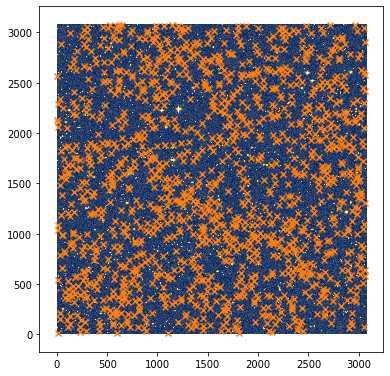

In [18]:
ax = zimg.show('dataclean')
ax.scatter(x,y, marker='x', color='C1')

# Select star to duplicate

### Set it yourself with _star_idx = int_

In [90]:
star_idx = 500

## Actual patching

In [91]:
stamp = zimg.get_stamps(x_list[star_idx],
                        y_list[star_idx],
                        dx=23)

#### Plot the patch if you want

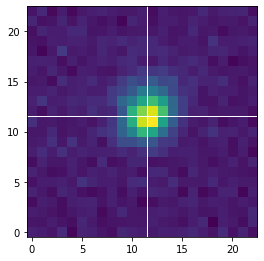

In [124]:
plt.close()
stamp.show()

## Choose the patch's _x, y_ translations, and inject it

### Compute the distances between the chosen star and all the others

In [93]:
origin = np.asarray([x_list[star_idx], y_list[star_idx]])
stars_coords = np.dstack([x_list.ravel(), y_list.ravel()])[0]
dist_from_idx = cdist([origin], stars_coords)[0]

### Choose the stars that are less than _D_ pixels from chosen one

In [94]:
D = 100
nearest_mask = (dist_from_idx < D) & (dist_from_idx > 0)
nearest_idx = np.where(nearest_mask == True)[0]
print(nearest_idx)
print(dist_from_idx[nearest_idx])

[ 100  417  418  440  510  589 1013]
[82.64169969 98.07922205 84.28163908 88.94158327 41.18730906 85.08254769
 60.76656323]


### Choose the nearest star wanted

In [119]:
idx = -2
x_nearest, y_nearest = stars_coords[nearest_idx[idx]]

### Plot the ztfimg around the future patch, to see before/after

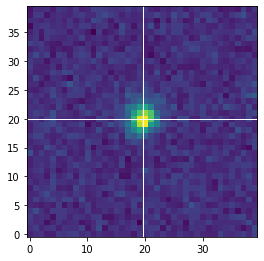

In [120]:
view_x_inc = 0
view_y_inc = 0
view_size = 40
ztf_zoomed = zimg.get_stamps(x_nearest+view_x_inc,
                             y_nearest+view_y_inc,
                             view_size, view_size)
ztf_zoomed.show()

### Choose the distance _r_ and angle _theta_ from chosen nearest star to put the stamp

In [121]:
r = 15
theta = 45
theta_rad = theta*np.pi/180

x_inc = r*np.cos(theta_rad)
y_inc = r*np.sin(theta_rad)

In [122]:
zimg.datafake = stamp.insert_to(zimg.data,
                                x_nearest+x_inc,
                                y_nearest+y_inc)

## Visualize change

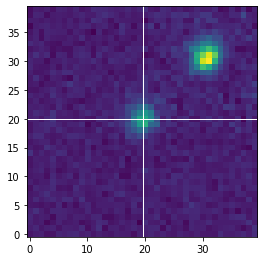

In [123]:
ztf_patched = zimg.get_stamps(x_nearest+view_x_inc,
                              y_nearest+view_y_inc,
                              view_size, view_size,
                              'datafake')
ztf_patched.show()

# Create new fake.fits from modified data

#### Convert to cell (y) to run

FILE_OUT = sciimg[:-11] + 'fake_' + sciimg[-11:]

fake_sci = fits.HDUList(fits.PrimaryHDU(data=zimg.datafake,
                                        header=header))
fake_sci.writeto(FILE_OUT, overwrite=True)

# Check if new file has the new star

In [32]:
zimg_f = image.ScienceImage(FILE_OUT, mask)
zimg_f.load_source_background()

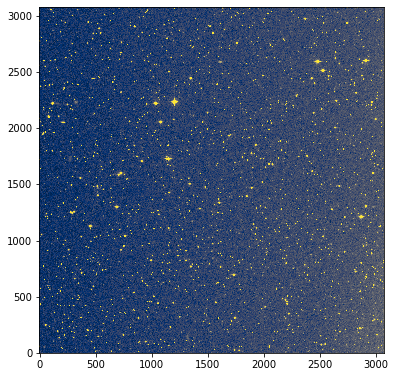

In [33]:
zimg_f.show('data')

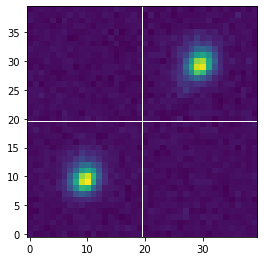

In [34]:
fake_test = zimg_f.get_stamps(x[star_idx]+view_x_inc,
                              y[star_idx]+view_y_inc,
                              view_size, view_size)
fake_test.show()